In [36]:
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold
from keras.utils import plot_model ,to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Dropout,Lambda,Activation, Input,MaxPooling2D, BatchNormalization, Concatenate, GlobalMaxPooling2D,AveragePooling2D
from keras.optimizers import Adam, schedules
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import vgg16 ,VGG19 ,ResNet152V2 ,DenseNet201
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
!pip install -q -U keras-tuner
import keras_tuner as kt
seed = 72
tf.random.set_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/archive.zip

# Data

In [38]:
train_data=pd.read_csv('/content/fashion-mnist_train.csv')
test_data=pd.read_csv('/content/fashion-mnist_test.csv')

In [ ]:
train_data.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [ ]:
train_data.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


# clean data

## 1.Nulls

In [ ]:
train_data.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [ ]:
test_data.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

**no nulls**

## 2.Duplicates

In [ ]:
train_data.duplicated().sum()

43

In [ ]:
test_data.duplicated().sum()

1

In [39]:
train_data.drop_duplicates(inplace = True)

In [40]:
test_data.drop_duplicates(inplace = True)

##3.Outliers

In [ ]:
train_data.describe(percentiles=[.025, .975])

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,...,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000
mean,4.500409,0.000901,0.006154,0.035342,0.102006,0.248094,0.411762,0.805744,2.197325,5.677802,...,34.620695,23.294528,16.581634,17.846190,22.799039,17.908901,8.523859,2.755275,0.856130,0.070300
std,2.872572,0.094723,0.271108,1.222756,2.453749,4.308444,5.838271,8.217037,14.090882,23.816347,...,57.546358,48.852671,41.974171,43.933567,51.815466,45.152503,29.622113,17.403733,9.360287,2.126631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.5%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
97.5%,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,24.000000,87.000000,...,190.000000,175.000000,160.000000,165.000000,183.000000,171.000000,113.000000,37.000000,0.000000,0.000000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.000000


# Visualization

<Axes: xlabel='label'>

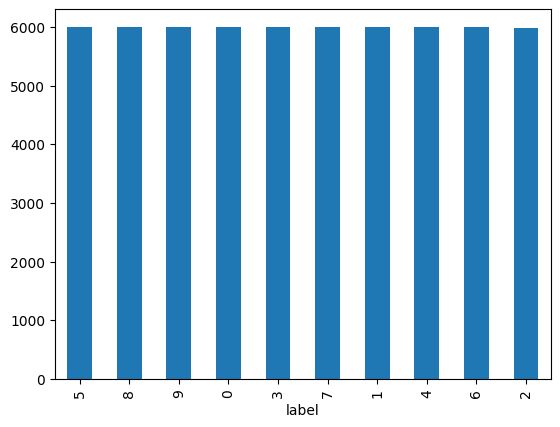

In [ ]:
train_data.label.value_counts().plot(kind='bar')


<Axes: xlabel='label'>

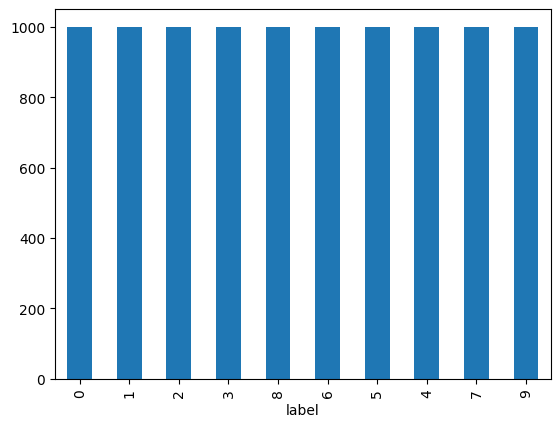

In [ ]:
test_data.label.value_counts().plot(kind='bar')

In [ ]:
labels=['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [41]:
data=pd.DataFrame(train_data.drop(['label'],axis=1).values)
target=train_data['label'].values

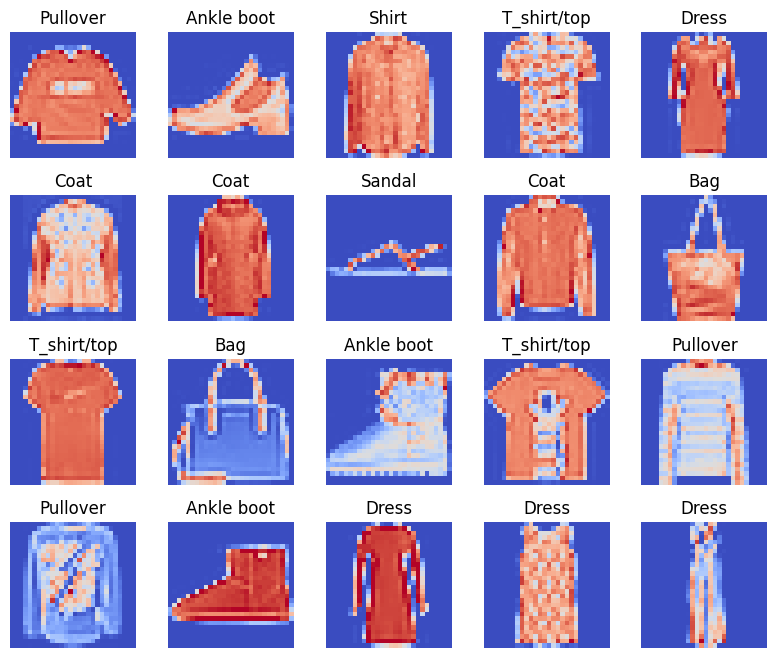

In [ ]:
img = data.values.reshape(-1, 28, 28)
num_images = 20
labels = train_data.iloc[:num_images, 0].map({0: 'T_shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
                                               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'})

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

for index, ax in enumerate(axes.flat):
    if index < num_images:
        ax.imshow(img[index], cmap= 'coolwarm')
        ax.set_title(labels[index])
        ax.axis('off')
    else:
        ax.axis('off')

plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# correlation

In [ ]:
data_corr=train_data.corr()
data_corr

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
label,1.000000,-0.000676,0.002942,-0.010453,-0.007119,-0.004629,-0.011058,-0.036828,-0.085385,-0.161761,...,-0.362817,-0.258533,-0.183235,-0.090386,-0.077161,-0.066846,-0.018054,0.045588,0.059963,0.021773
pixel1,-0.000676,1.000000,0.297899,0.067551,0.046607,0.026630,0.026172,0.012096,0.012225,0.009644,...,-0.000641,0.004628,0.004609,0.000975,-0.002305,-0.002442,-0.000109,0.008764,0.026388,0.041581
pixel2,0.002942,0.297899,1.000000,0.575033,0.138709,0.054353,0.033184,0.022766,0.017138,0.016821,...,0.000494,0.004861,0.006817,0.002097,-0.004427,-0.002341,0.004271,0.014215,0.021296,0.022161
pixel3,-0.010453,0.067551,0.575033,1.000000,0.387468,0.118136,0.087300,0.060937,0.035942,0.029674,...,0.010095,0.016706,0.018323,0.006163,-0.003821,-0.001494,0.006861,0.013151,0.009946,0.015657
pixel4,-0.007119,0.046607,0.138709,0.387468,1.000000,0.573172,0.325683,0.242987,0.141033,0.085302,...,0.009690,0.018710,0.023391,0.016759,0.009700,0.010101,0.023940,0.012388,0.003072,0.008422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel780,-0.066846,-0.002442,-0.002341,-0.001494,0.010101,0.021514,0.032318,0.027065,0.019507,0.024986,...,-0.074218,-0.008964,0.043000,0.336772,0.790184,1.000000,0.749621,0.349134,0.178656,0.073421
pixel781,-0.018054,-0.000109,0.004271,0.006861,0.023940,0.025971,0.038560,0.030478,0.026278,0.034245,...,-0.042288,0.008640,0.045504,0.131133,0.439563,0.749621,1.000000,0.645871,0.334548,0.133829
pixel782,0.045588,0.008764,0.014215,0.013151,0.012388,0.028859,0.044113,0.029461,0.022747,0.020991,...,-0.002795,0.034103,0.074004,0.092843,0.152620,0.349134,0.645871,1.000000,0.658959,0.225500
pixel783,0.059963,0.026388,0.021296,0.009946,0.003072,0.022939,0.030802,0.016128,0.005947,0.000090,...,0.001906,0.026552,0.054235,0.077767,0.101160,0.178656,0.334548,0.658959,1.000000,0.451929


Principal Component 1: 0.2900949619046062
Principal Component 2: 0.1772913168403364
Principal Component 3: 0.06022032294859243
Principal Component 4: 0.04969974824484935
Principal Component 5: 0.038403795312845185
Principal Component 6: 0.03470215823024348
Principal Component 7: 0.023438655670610764
Principal Component 8: 0.019141410648901895
Principal Component 9: 0.013436561112010878
Principal Component 10: 0.013107193773834194
Principal Component 11: 0.009898611516204102
Principal Component 12: 0.009136765619100595
Principal Component 13: 0.007652571591170914
Principal Component 14: 0.006603480586983522
Principal Component 15: 0.006093423050782067
Principal Component 16: 0.005915955936880296
Principal Component 17: 0.005521726072485493
Principal Component 18: 0.005305500534417187
Principal Component 19: 0.004600227990564847
Principal Component 20: 0.004554661466498198
Principal Component 21: 0.004328459429020874
Principal Component 22: 0.004061431753054469
Principal Component 23: 0.

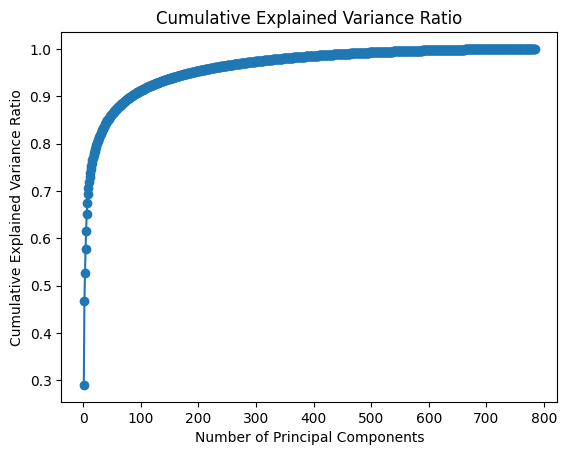

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)

explained_variance_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio}")

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(np.arange(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.show()

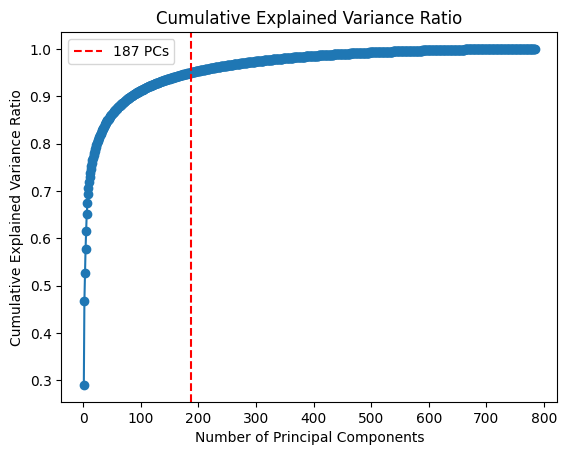

Number of components needed to capture 95.0% of the variance: 187


In [ ]:
num_components = len(explained_variance_ratio)
plt.plot(np.arange(1, num_components + 1), cumulative_explained_variance_ratio, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')

# Set the desired threshold for variance capture
desired_variance = 0.95

# Find the number of components needed to capture the desired variance
num_components_needed = np.argmax(cumulative_explained_variance_ratio >= desired_variance) + 1
plt.axvline(x=num_components_needed, color='r', linestyle='--', label=f'{num_components_needed} PCs')

plt.legend()
plt.show()

# Print the number of components needed to capture the desired variance
print(f"Number of components needed to capture {desired_variance * 100}% of the variance: {num_components_needed}")

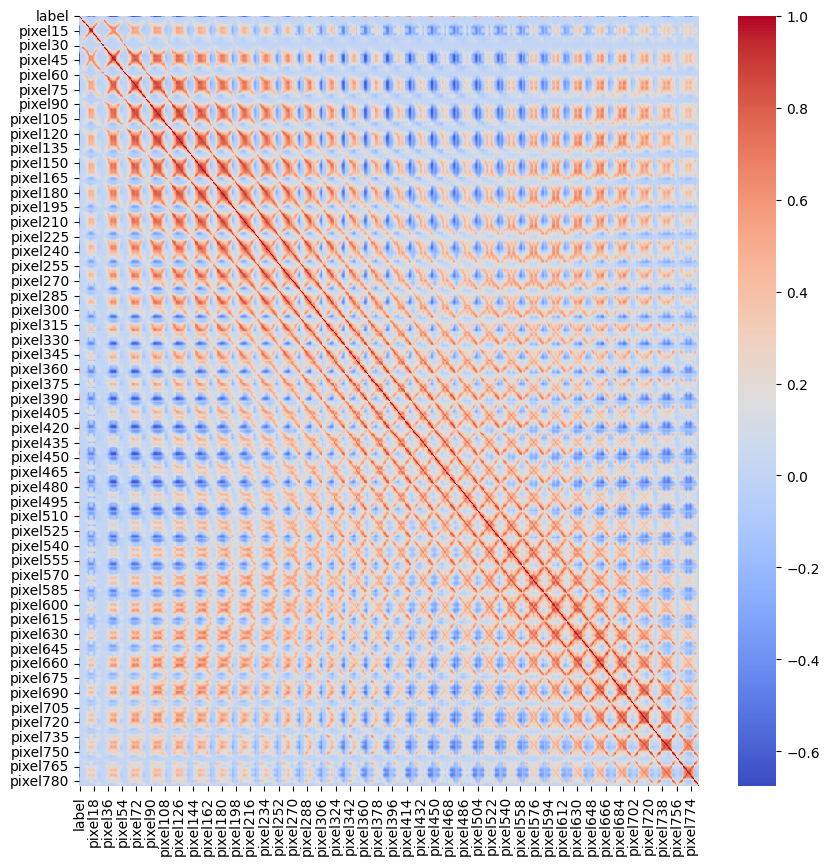

In [ ]:
figure, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(data_corr, cmap='coolwarm')
plt.show()

# Preprocessing

# Scaling

In [42]:
num_images = data.shape[1]
image_data = np.array(data.values.reshape(-1, 28, 28))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(image_data.reshape(num_images, -1)).reshape((-1, 28, 28))



# Encoding

In [43]:
encoder=LabelEncoder()
target=encoder.fit_transform(target)
np.unique(target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Data splitting

In [44]:
X_train,X_val,y_train,y_val=train_test_split(scaled_data,target,test_size=.2,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=.3,random_state=42)

# MLP

In [33]:
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
optimizer = Adam()
loss_function = SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train the model
batch_size = 128
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
375/375 [==============================] - 4s 7ms/step - loss: 0.5722 - accuracy: 0.7992 - val_loss: 0.4305 - val_accuracy: 0.8479
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 0.4028 - accuracy: 0.8570 - val_loss: 0.3763 - val_accuracy: 0.8655
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.3654 - accuracy: 0.8694 - val_loss: 0.3490 - val_accuracy: 0.8723
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3324 - accuracy: 0.8801 - val_loss: 0.3426 - val_accuracy: 0.8744
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3131 - accuracy: 0.8872 - val_loss: 0.3361 - val_accuracy: 0.8773
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2989 - accuracy: 0.8919 - val_loss: 0.3521 - val_accuracy: 0.8703
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2859 - accuracy: 0.8952 - val_loss: 0.3333 - val_accuracy: 0.8784
Epoch 

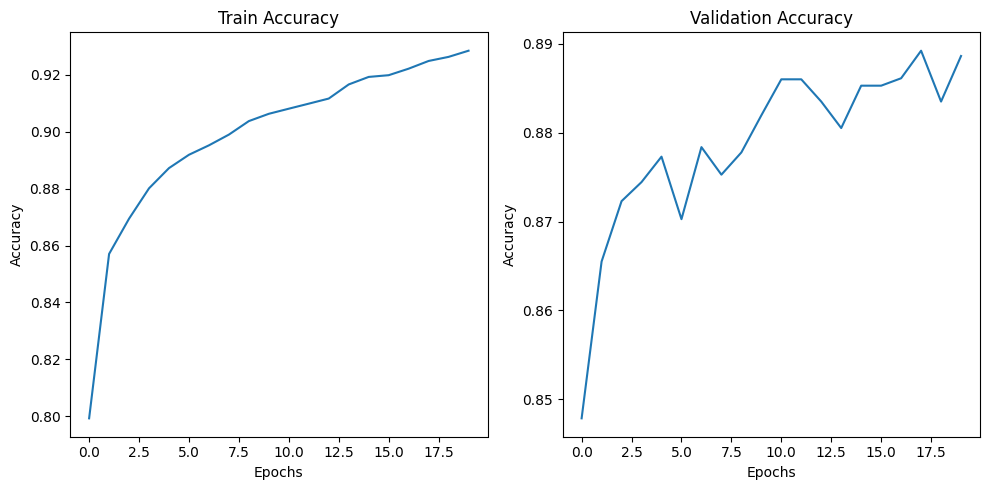

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

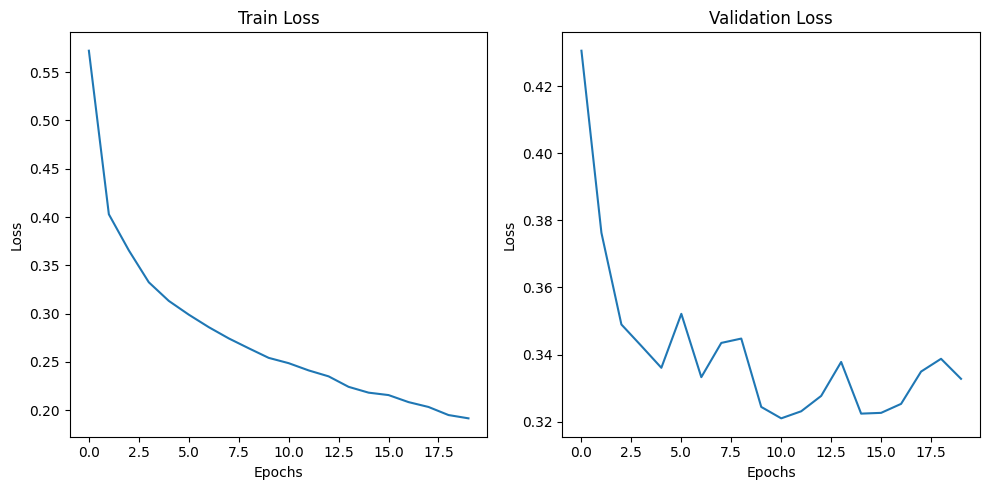

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

## building LeNet5 model


In [ ]:
def lenet_model (hyper):

    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(AveragePooling2D(strides=2,pool_size=(3,3)))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(AveragePooling2D(strides=2,pool_size=(3,3)))
    model.add(Flatten())
    hyper_units = hyper.Choice('units', values=[120, 240])
    model.add(Dense(units=hyper_units, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    hyper_learning_rate = hyper.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hyper_learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

## Early Stopping Conditions

In [46]:
earlyStop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
def hyper_search(lenet_model, X_train, y_train, X_val, y_val):
  tunning = kt.Hyperband(lenet_model, objective='val_accuracy', seed=seed, overwrite=True)
  tunning.search(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, callbacks=[earlyStop])
  return tunning

In [ ]:
tunning = hyper_search(lenet_model, X_train, y_train, X_val, y_val)

Trial 8 Complete [00h 00m 08s]
val_accuracy: 0.7617345452308655

Best val_accuracy So Far: 0.8355968594551086
Total elapsed time: 00h 01m 13s


In [ ]:
best_hps = tunning.get_best_hyperparameters(num_trials=1)[0]
_learning_rate = best_hps.get('learning_rate')

print(f"""
 optimal number of units=  {best_hps.get('units')}
 optimal learning rate= {_learning_rate}.
""")


 optimal number of units=  120 
 optimal learning rate= 0.01.



In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_8 (Avera  (None, 12, 12, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 4, 4, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 240)              

In [ ]:
def fitting (X_train, y_train, X_val, y_val):
  model = tunning.hypermodel.build(best_hps)
  history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val), callbacks=[earlyStop])
  return history, model
history, model = fitting(X_train, y_train, X_val, y_val)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6120 - loss: 1.0179 - val_accuracy: 0.7891 - val_loss: 0.5287
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8033 - loss: 0.5142 - val_accuracy: 0.8310 - val_loss: 0.4425
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.4273 - val_accuracy: 0.8419 - val_loss: 0.4256
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8595 - loss: 0.3812 - val_accuracy: 0.8550 - val_loss: 0.3828
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8682 - loss: 0.3541 - val_accuracy: 0.8624 - val_loss: 0.3810
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8753 - loss: 0.3409 - val_accuracy: 0.8679 - val_loss: 0.3546
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8758 - loss: 0.3354 - val_accuracy: 0.8706 - val_loss: 0.3503
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8832 - loss: 0.3164 - val_accuracy: 0

In [ ]:
# find best epoch
epoch_val_acc = history.history['val_accuracy']
bestEpoch = epoch_val_acc.index(max(epoch_val_acc)) + 1
print('Best Epoch: %d' % (bestEpoch,))

Best Epoch: 17


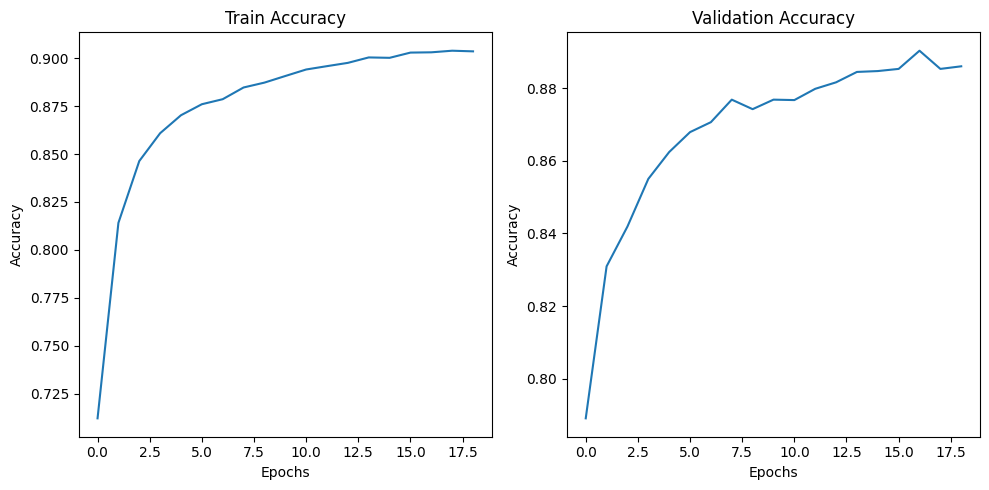

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

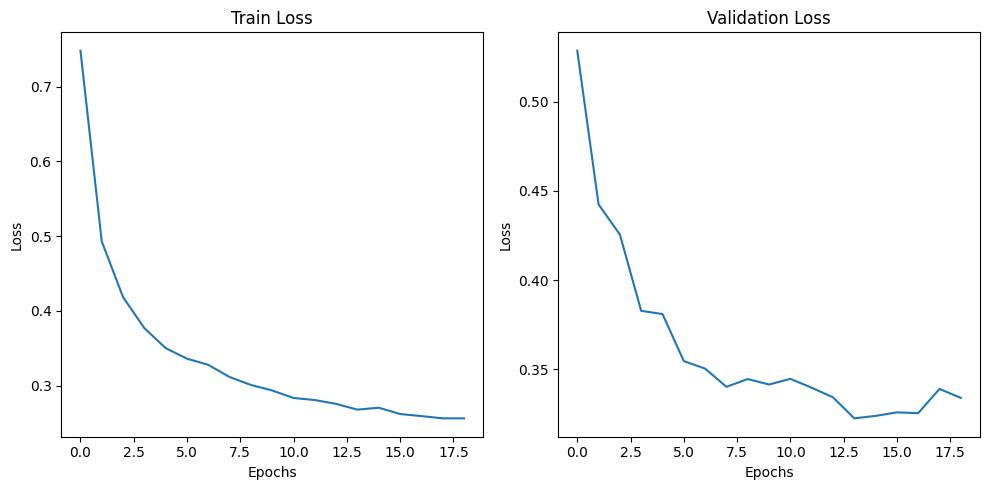

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
Eval = model.evaluate(X_test, y_test)
print(Eval)
print(f'Evaluation Score for: {model.metrics_names[0]} of {Eval[0]}; {model.metrics_names[1]} of {Eval[1] * 100}%')

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8758 - loss: 0.3492
[0.35011032223701477, 0.8777098655700684]
Evaluation Score for: loss of 0.35011032223701477; compile_metrics of 87.77098655700684%


In [ ]:
no_folds = 5
k_fold = KFold(n_splits=no_folds, shuffle=True, random_state=seed)

In [ ]:
fold = 1
models = []
accuracies = []
losses = []

for train, val in k_fold.split(X_train, y_train):
    print(f'Start of fold {fold} ...')
    history, model = fitting(X_train, y_train, X_val, y_val)
    scores = model.evaluate(X_test, y_test)
    print(scores)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    models.append(model)
    accuracies.append(scores[1] * 100)
    losses.append(scores[0])
    print(f'End of fold {fold} ...')

    fold += 1

Start of fold 1 ...

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6121 - loss: 1.0283 - val_accuracy: 0.8026 - val_loss: 0.4970
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8255 - loss: 0.4654 - val_accuracy: 0.8458 - val_loss: 0.4246
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8504 - loss: 0.3988 - val_accuracy: 0.8604 - val_loss: 0.3817
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8654 - loss: 0.3643 - val_accuracy: 0.8611 - val_loss: 0.3670
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8751 - loss: 0.3404 - val_accuracy: 0.8679 - val_loss: 0.3545
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8630 - loss: 0.3624
[0.36238107085227966, 0.8652029037475586]
Score for fold 1: loss of 0.36238107085227966; compile_metrics of 86.52029037475586%

End of fold 1 ...
Start of fold 2 ...

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6078 - loss: 1.0263 - val_acc

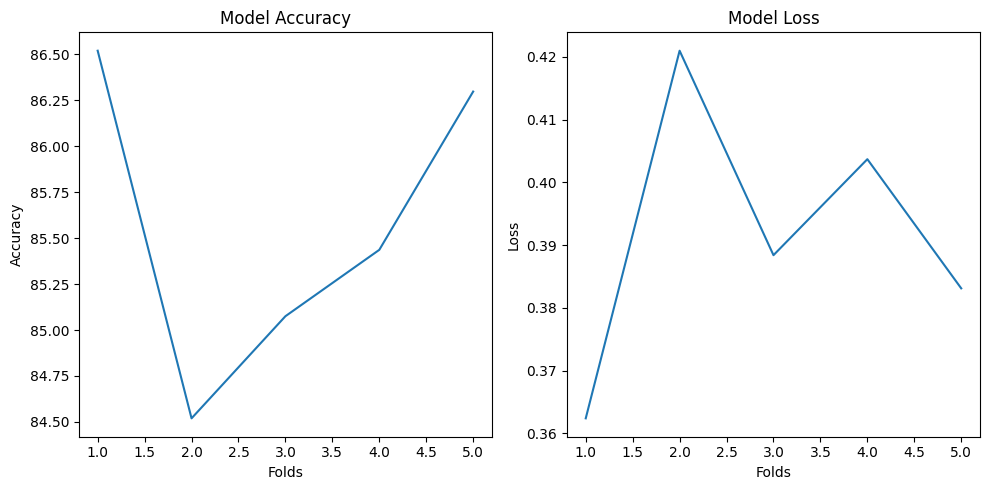

In [ ]:
folds=(1,2,3,4,5)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(folds, accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.subplot(1, 2, 2)
plt.plot(folds, losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Folds')
plt.tight_layout()
plt.show()

# Transfer Learning

## Learning rate decay function

In [45]:
def lr_decay(epoch, learning_rate):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch > 0:
        return learning_rate * decay_rate
    return learning_rate

lr_scheduler = LearningRateScheduler(lr_decay)



In [47]:
df = data.values
reshaped_data = df.reshape(data.shape[0], 28, 28)
resized_images = np.zeros((df.shape[0], 32, 32, 3))
for i in range(df.shape[0]):
    resized_images[i] = np.resize(reshaped_data[i], (32, 32, 3))
print(resized_images.shape)

(59957, 32, 32, 3)


In [48]:
X_train,X_val,y_train,y_val=train_test_split(resized_images,target,test_size=.2,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=.3,random_state=42)

In [ ]:
Ytrain_one_hot = to_categorical(y_train)
Ytest_one_hot = to_categorical(y_test)

In [ ]:
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])
train_X.shape, test_X.shape

((47965, 48, 48, 3), (3598, 48, 48, 3))

In [ ]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = preprocess_input(train_X)
test_X = preprocess_input(test_X)

# VGG16

In [ ]:
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
model.trainable = False
flatten = Flatten()
new_layer2 = Dense(10, activation='softmax')
inp2 = model.input
out2 = new_layer2(flatten(model.output))

model2 = Model(inp2, out2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model2.fit(train_X,Ytrain_one_hot,validation_data=(test_X, Ytest_one_hot),
                     epochs=20,batch_size=256,
                     verbose=1,
                     callbacks=[earlyStop,lr_scheduler])

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 103ms/step - accuracy: 0.1071 - loss: 5.2347 - val_accuracy: 0.2154 - val_loss: 2.1224 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.2477 - loss: 2.0776 - val_accuracy: 0.2685 - val_loss: 1.9964 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.3119 - loss: 1.9598 - val_accuracy: 0.3218 - val_loss: 1.9165 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.3544 - loss: 1.8812 - val_accuracy: 0.3535 - val_loss: 1.8570 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.3774 - loss: 1.8220 - val_accuracy: 0.3699 - val_loss: 1.8099 - learning_rate: 0.0010
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.3932 - loss: 1.7751 - val_accuracy: 0.3841 - val_loss: 1.7712 - learning_rate: 0.0010
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4040 - 

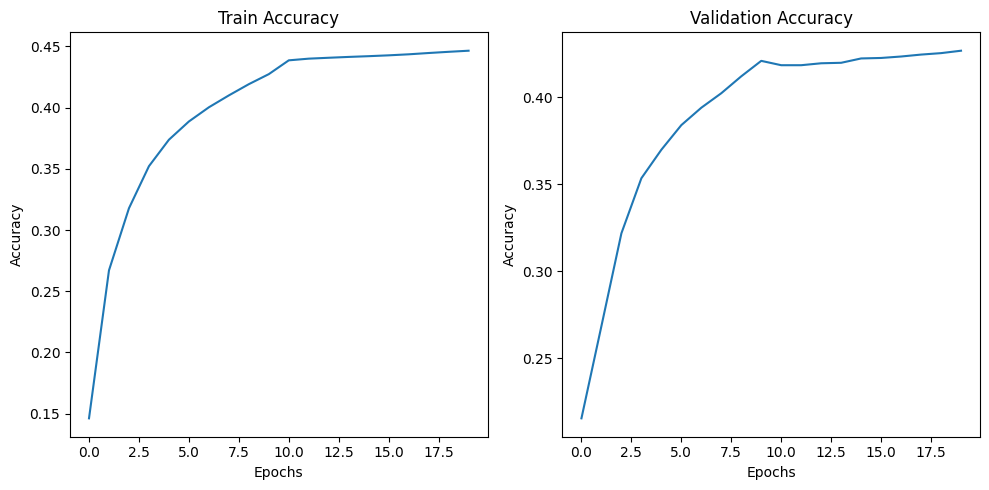

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

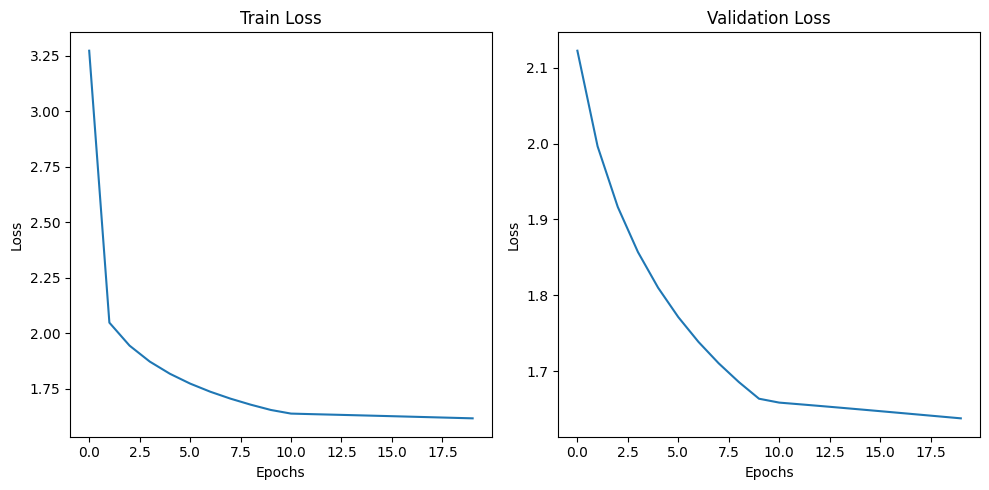

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# VGG19

In [49]:
def VGG19_builder():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [50]:
vgg19_model = VGG19_builder()
vgg19_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                 

In [51]:
vgg_history = vgg19_model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val),callbacks=[earlyStop,lr_scheduler])

Epoch 1/20
188/188 [==============================] - 40s 141ms/step - loss: 552817792.0000 - accuracy: 0.1011 - val_loss: 2.3028 - val_accuracy: 0.1020 - lr: 0.0100
Epoch 2/20
188/188 [==============================] - 20s 104ms/step - loss: 2.3029 - accuracy: 0.0973 - val_loss: 2.3028 - val_accuracy: 0.1027 - lr: 0.0100
Epoch 3/20
188/188 [==============================] - 20s 105ms/step - loss: 2.3029 - accuracy: 0.0982 - val_loss: 2.3028 - val_accuracy: 0.1002 - lr: 0.0100
Epoch 4/20
188/188 [==============================] - 20s 106ms/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 2.3030 - val_accuracy: 0.1002 - lr: 0.0100
Epoch 5/20
188/188 [==============================] - 20s 108ms/step - loss: 2.3029 - accuracy: 0.0987 - val_loss: 2.3029 - val_accuracy: 0.1020 - lr: 0.0100
Epoch 6/20
188/188 [==============================] - 20s 109ms/step - loss: 2.3029 - accuracy: 0.1011 - val_loss: 2.3028 - val_accuracy: 0.0991 - lr: 0.0100


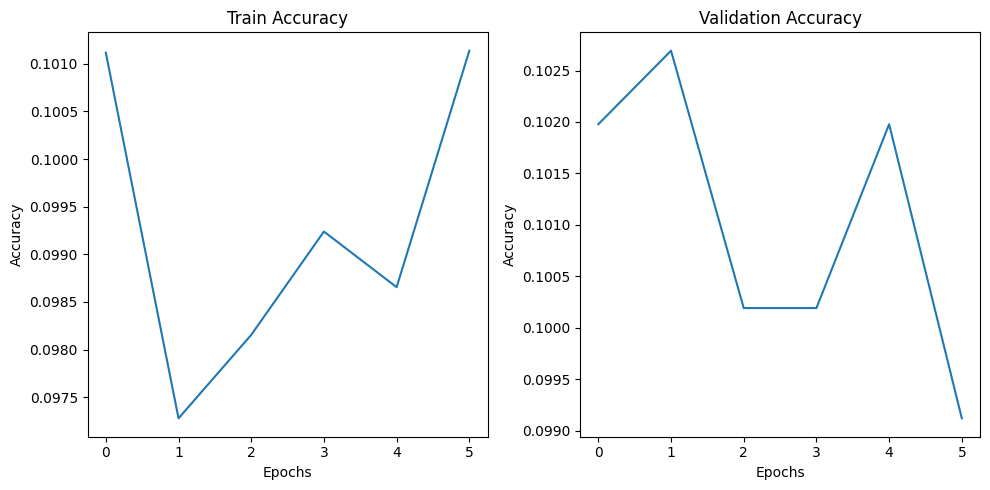

In [52]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

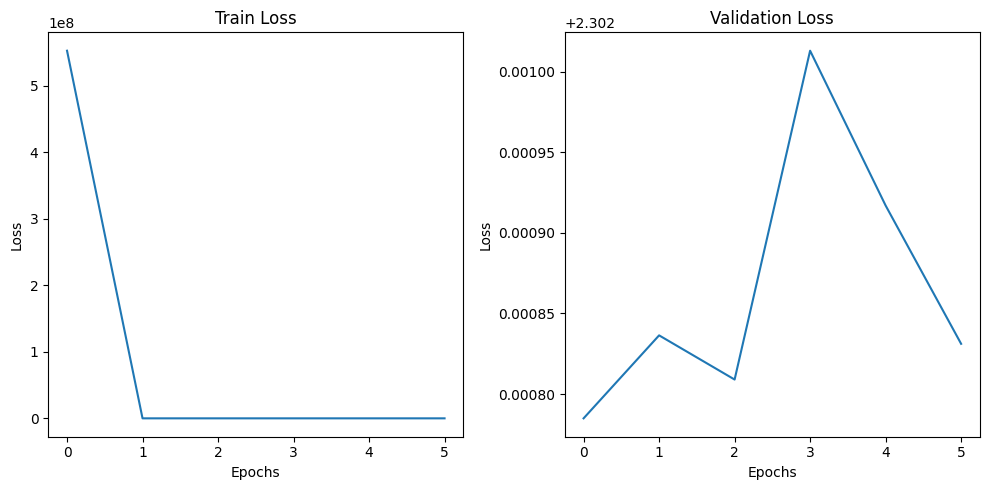

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# RESNet152V2

In [17]:
def ResNet_builder():
    img_input = Input(shape=(32, 32, 3))
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_tensor=img_input)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [18]:
resnet_model = ResNet_builder()
resnet_model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                           

In [19]:
res_history = resnet_model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val), callbacks=[earlyStop,lr_scheduler])

Epoch 1/20
188/188 [==============================] - 34s 97ms/step - loss: 34.8635 - accuracy: 0.0986 - val_loss: 2.3029 - val_accuracy: 0.0960 - lr: 0.0100
Epoch 2/20
188/188 [==============================] - 14s 73ms/step - loss: 2.3089 - accuracy: 0.0972 - val_loss: 2.3029 - val_accuracy: 0.1027 - lr: 0.0100
Epoch 3/20
188/188 [==============================] - 13s 69ms/step - loss: 2.3150 - accuracy: 0.0974 - val_loss: 2.3029 - val_accuracy: 0.1002 - lr: 0.0100
Epoch 4/20
188/188 [==============================] - 13s 69ms/step - loss: 2.4023 - accuracy: 0.1002 - val_loss: 2.3030 - val_accuracy: 0.1002 - lr: 0.0100
Epoch 5/20
188/188 [==============================] - 14s 76ms/step - loss: 2.3030 - accuracy: 0.0994 - val_loss: 2.3030 - val_accuracy: 0.1005 - lr: 0.0100
Epoch 6/20
188/188 [==============================] - 14s 74ms/step - loss: 2.3074 - accuracy: 0.1018 - val_loss: 2.3029 - val_accuracy: 0.0991 - lr: 0.0100
Epoch 7/20
188/188 [==============================] - 13s

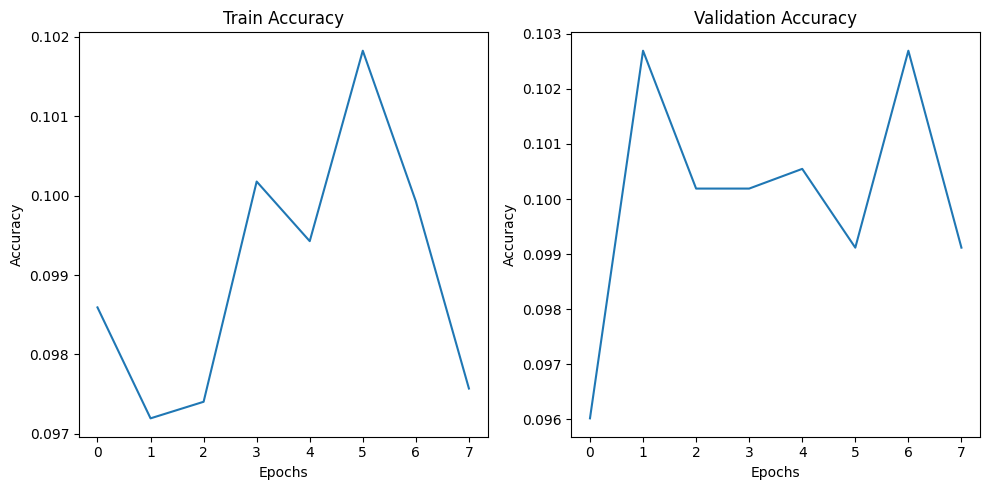

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(res_history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(res_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

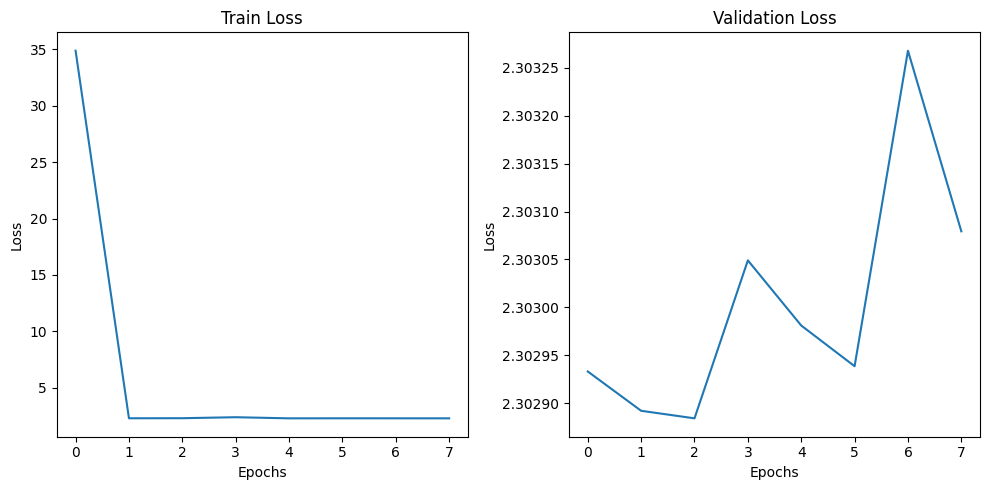

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(res_history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(res_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# DenseNet201

In [ ]:
def DenseNet_builder():
    img_input = Input(shape=(32, 32, 3))
    base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=img_input)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
densenet_model = ResNet_builder()
dense_history = densenet_model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
188/188 [==============================] - 15s 79ms/step - loss: 2.3049 - accuracy: 0.0977 - val_loss: 2.3037 - val_accuracy: 0.0936
Epoch 2/10
188/188 [==============================] - 14s 77ms/step - loss: 2.3031 - accuracy: 0.0984 - val_loss: 2.3032 - val_accuracy: 0.1039
Epoch 3/10
188/188 [==============================] - 14s 73ms/step - loss: 2.3032 - accuracy: 0.1005 - val_loss: 2.3026 - val_accuracy: 0.0968
Epoch 4/10
188/188 [==============================] - 14s 77ms/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 2.3042 - val_accuracy: 0.0936
Epoch 5/10
188/188 [==============================] - 14s 72ms/step - loss: 2.3032 - accuracy: 0.0980 - val_loss: 2.3034 - val_accuracy: 0.1049
Epoch 6/10
188/188 [==============================] - 14s 72ms/step - loss: 2.3058 - accuracy: 0.0995 - val_loss: 2.3029 - val_accuracy: 0.1014
Epoch 7/10
188/188 [==============================] - 14s 73ms/step - loss: 2.3072 - accuracy: 0.0991 - val_loss: 2.3034 - val_accuracy:

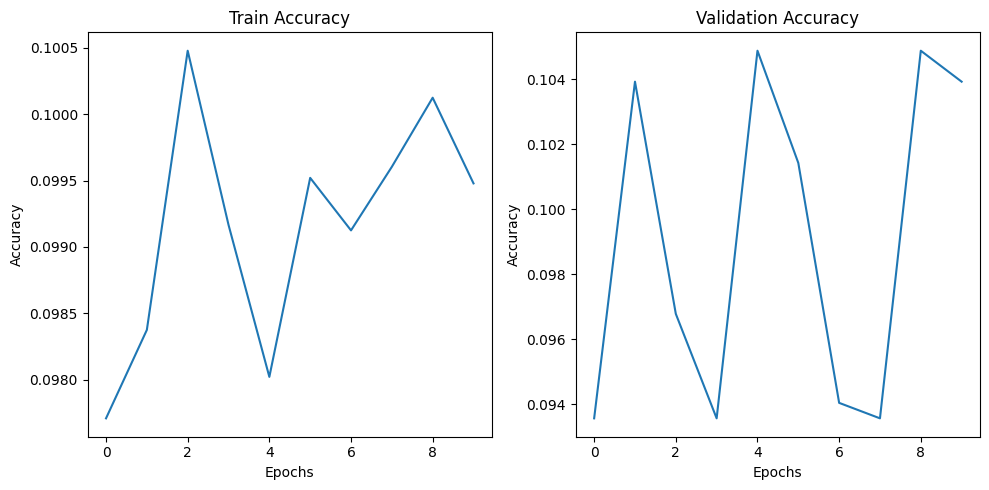

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(dense_history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(dense_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

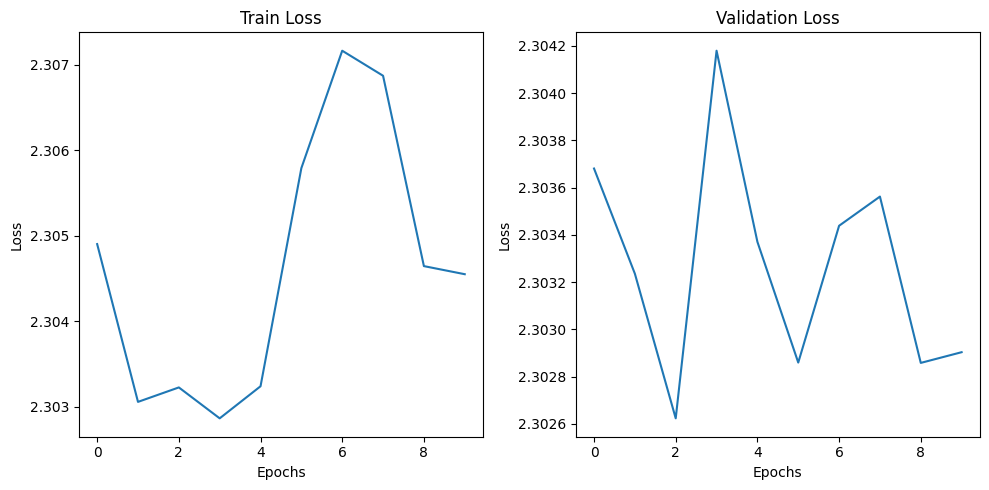

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(dense_history.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(dense_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()